<a href="https://colab.research.google.com/github/claudio1975/Generative_Modelling/blob/main/CDF/Synthetic_Data_with_CDF_D1_D2_60_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap &> /dev/null

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model,Input
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, make_scorer
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import KFold
import shap
from sklearn.mixture import GaussianMixture
from joblib import dump
from joblib import load

import warnings
warnings.filterwarnings('ignore')

In [3]:
DEFAULT_RANDOM_SEED = 0 # Set a random seed for reproducibility throughout Python, NumPy, and TensorFlow operations
random.seed(DEFAULT_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(DEFAULT_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(DEFAULT_RANDOM_SEED)
tf.random.set_seed(DEFAULT_RANDOM_SEED)

In [4]:
pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                          

### Functions

In [5]:
# --- seeds
np.random.seed(0)
tf.random.set_seed(0)

def train_cdf_model(
    X_train,
    condition_col,
    target_discrete,
    target_continuous,
    timesteps,
    beta_start,
    t_emb_dim,
    beta_end,
    hidden_dim,
    epochs,
    batch_size,
    learning_rate,
    seed=0
):
    """
    Trains a *conditional diffusion* model (UNet denoiser + DDPM schedule) on the given dataset.

    Parameters
    ----------
    X_train : Training data frame. Must include `condition_col`, `target_discrete`, `target_continuous`.
    condition_col : Name of the binary condition column kept unnormalized and appended to inputs.
    target_discrete : Discrete target column (e.g., 'ClaimNb').
    target_continuous : Continuous target column (e.g., 'ClaimAmount').
    timesteps : Number of diffusion steps.
    beta_start, beta_end : Linear beta schedule endpoints.
    hidden_dim : Width for MLP blocks in the UNet-like tabular denoiser.
    epochs : Training epochs.
    batch_size : Batch size.
    learning_rate : Adam learning rate.
    seed : Random seed for numpy/tensorflow.

    Returns
    -------
    cdf : dict
        A simple container with:
        - 'unet' : trained Keras Model taking [x_noised, t, condition] → predicted noise
        - 'diffusion' : DiffusionModel instance (beta/alpha schedules, q_sample)
        - 'means' : np.ndarray means (for inverse transform)
        - 'stds_corrected' : np.ndarray stds with zeros replaced by 1 (for inverse transform)
        - 'features' : list of feature names reconstructed by the model (excludes condition column)
        - 'condition_col' : the name used for conditioning
        - 'condition_dim' : int (usually 1)
        - 'input_dim' : features + condition
    """


    # --- split features / condition (decoder reconstructs *features* only; condition is appended)
    features = [c for c in X_train.columns if c != condition_col]
    X_features = X_train[features].values.astype('float32')
    X_condition = X_train[condition_col].values.reshape(-1, 1).astype('float32')

    # --- normalize features (store exact stats for inverse-transform later)
    means = np.mean(X_features, axis=0).astype('float32')
    stds = np.std(X_features, axis=0).astype('float32')
    stds_corrected = np.where(stds == 0.0, 1.0, stds).astype('float32')
    X_features_norm = ((X_features - means) / stds_corrected).astype('float32')

    # model input is [features_norm || condition]
    X_input = np.concatenate([X_features_norm, X_condition], axis=1).astype('float32')
    input_dim = X_input.shape[1]
    condition_dim = X_condition.shape[1]

    # --- diffusion schedule (same structure as your notebook)
    class DiffusionModel:
        def __init__(self, input_dim, timesteps=1000, beta_start=1e-4, beta_end=0.02):
            import numpy as np, tensorflow as tf
            self.input_dim = input_dim
            self.timesteps = timesteps
            self.beta = np.linspace(beta_start, beta_end, timesteps, dtype=np.float32)
            self.alpha = 1.0 - self.beta
            self.alpha_cumprod = np.cumprod(self.alpha).astype(np.float32)
            self.alpha_cumprod_prev = np.concatenate(
                (np.array([1.0], dtype=np.float32), self.alpha_cumprod[:-1])
            ).astype(np.float32)

        def q_sample(self, x_start, t, noise=None):
            import tensorflow as tf
            if noise is None:
                noise = tf.random.normal(shape=x_start.shape, dtype=tf.float32)
            alpha_cumprod = tf.constant(self.alpha_cumprod, dtype=tf.float32)
            one = tf.constant(1.0, dtype=tf.float32)
            sqrt_alpha_cumprod = tf.sqrt(tf.gather(alpha_cumprod, t))[:, None]
            sqrt_one_minus_alpha_cumprod = tf.sqrt(tf.gather(one - alpha_cumprod, t))[:, None]
            return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha_cumprod * noise

    diffusion = DiffusionModel(input_dim=input_dim, timesteps=timesteps,
                               beta_start=beta_start, beta_end=beta_end)

    # --- UNet-ish MLP for tabular noise prediction (same idea as your current one)
    def build_unet(input_dim, condition_dim, timesteps, hidden_dim):
        x_in = layers.Input(shape=(input_dim,), dtype='float32', name='x_in')
        t_in = layers.Input(shape=(), dtype='int32', name='timestep')
        c_in = layers.Input(shape=(condition_dim,), dtype='float32', name='condition')

        # timestep embedding via embedding + small MLP
        t_emb = layers.Embedding(input_dim=timesteps, output_dim=64, dtype='float32')(t_in)
        t_emb = layers.Dense(t_emb_dim, activation='relu')(t_emb)
        t_emb = layers.Dense(t_emb_dim, activation='relu')(t_emb)

        # concat and encoder/decoder with skips
        x = layers.Concatenate()([x_in, c_in, t_emb])
        e1 = layers.Dense(hidden_dim, activation='relu')(x)
        e2 = layers.Dense(hidden_dim, activation='relu')(e1)
        e3 = layers.Dense(hidden_dim, activation='relu')(e2)
        b  = layers.Dense(hidden_dim, activation='relu')(e3)
        d1 = layers.Dense(hidden_dim, activation='relu')(b)
        d1 = layers.Concatenate()([d1, e3])
        d2 = layers.Dense(hidden_dim, activation='relu')(d1)
        d2 = layers.Concatenate()([d2, e2])
        d3 = layers.Dense(hidden_dim, activation='relu')(d2)
        d3 = layers.Concatenate()([d3, e1])

        # predict noise for ALL inputs (features+condition); we’ll train with MSE(noise, noise_pred)
        # but we only *use* the features part at generation time.
        out = layers.Dense(input_dim, activation='linear')(d3)
        return Model([x_in, t_in, c_in], out, name='unet_tabular_ddpm')

    unet = build_unet(input_dim=input_dim,
                      condition_dim=condition_dim,
                      timesteps=timesteps,
                      hidden_dim=hidden_dim)

    # --- data pipeline
    ds = tf.data.Dataset.from_tensor_slices((X_input, X_input[:, -condition_dim:])) \
                        .shuffle(1024) \
                        .batch(batch_size) \
                        .prefetch(tf.data.AUTOTUNE)

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # --- train loop
    for epoch in range(epochs):
      epoch_loss = 0.0
      for x_batch, c_batch in ds:
        t = tf.random.uniform((tf.shape(x_batch)[0],), 0, timesteps, dtype=tf.int32)
        noise = tf.random.normal(shape=x_batch.shape, dtype=tf.float32)
        x_noised = diffusion.q_sample(x_batch, t, noise)
        with tf.GradientTape() as tape:
            noise_pred = unet([x_noised, t, c_batch], training=True)
            loss = tf.reduce_mean(tf.square(noise - noise_pred))
        grads = tape.gradient(loss, unet.trainable_variables)
        opt.apply_gradients(zip(grads, unet.trainable_variables))
        epoch_loss += float(loss.numpy())
      print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f}")


    # bundle like a “model”
    cdf = {
        'unet': unet,
        'diffusion': diffusion,
        'means': means,
        'stds_corrected': stds_corrected,
        'features': features,
        'condition_col': condition_col,
        'condition_dim': condition_dim,
        'input_dim': input_dim,
        'timesteps': timesteps
    }
    return cdf




In [6]:
def generate_cdf_synthetic_data(
    cdf_model,
    num_samples,
    claim_occ_values,
    feature_names,
    means,
    stds_corrected,
    X_train,
    condition_col,
    target_discrete,
    target_continuous,
    timesteps,
    condition_dim,
    columns_to_round=None,
    seed=0
):
    """
    Generates synthetic data with a trained *conditional diffusion* model.

    Parameters
    ----------
    cdf_model : Return value from `train_cdf_model` (must contain 'unet' and 'diffusion').
    num_samples : Total number of rows to sample (will match the condition proportions of X_train).
    claim_occ_values : Allowed condition values, e.g. [0, 1].
    feature_names : Names of reconstructed features (excludes the condition column).
    means, stds_corrected : Same scaling stats from training for inverse-transform.
    X_train : Used only to keep the original ClaimOcc proportions.
    condition_col, target_discrete, target_continuous : Column names used for post-processing constraints.
    timesteps : Number of diffusion steps (must match training).
    condition_dim : Dimensionality of the condition vector (usually 1).
    columns_to_round : Extra integer columns to round (besides `target_discrete`).
    seed : Random seed.

    Returns
    -------
    synthetic_data : Combined and shuffled synthetic dataset.
    """

    unet = cdf_model['unet']
    diffusion = cdf_model['diffusion']

    # reverse diffusion sampler
    def sample_diffusion(model, diffusion, condition, n):
      x = tf.random.normal(shape=(n, diffusion.input_dim), dtype=tf.float32)

      # ensure the last columns (condition_dim) always equal the requested condition
      cond_dim = int(condition.shape[1])
      for t in tqdm(range(diffusion.timesteps-1, -1, -1), desc="Sampling", leave=False):
        # clamp before predicting
        x = tf.concat([x[:, :-cond_dim], condition], axis=1)

        t_tensor = tf.fill([n], t)
        noise_pred = model([x, t_tensor, condition], training=False)

        beta_t  = tf.constant(diffusion.beta[t], dtype=tf.float32)
        alpha_t = tf.constant(diffusion.alpha[t], dtype=tf.float32)
        alpha_bar_t = tf.constant(diffusion.alpha_cumprod[t], dtype=tf.float32)

        inv_sqrt_alpha_t = 1.0 / tf.sqrt(alpha_t)
        coef = (1.0 - alpha_t) / tf.sqrt(1.0 - alpha_bar_t)
        x = inv_sqrt_alpha_t * (x - coef * noise_pred)
        if t > 0:
          x = x + tf.sqrt(beta_t) * tf.random.normal(shape=(n, diffusion.input_dim), dtype=tf.float32)

          # clamp again after update so it doesn't drift
          x = tf.concat([x[:, :-cond_dim], condition], axis=1)

      return x

    # inner: sample a subset at a fixed ClaimOcc value (then inverse-transform + constraints)
    def generate_subset(n, occ_value):
        if n <= 0:
            return pd.DataFrame()
        # build condition tensor
        condition = np.full((n, condition_dim), occ_value, dtype='float32')
        condition_t = tf.convert_to_tensor(condition, dtype=tf.float32)

        x_noised = sample_diffusion(unet, diffusion, condition_t, n).numpy()
        # take *feature* part (assumes last column is condition in the model input)
        x_features_norm = x_noised[:, :-condition_dim]
        # inverse scale with exact training stats
        x_features = x_features_norm * stds_corrected + means

        df = pd.DataFrame(x_features, columns=feature_names)
        df[condition_col] = occ_value

        # discrete target
        if target_discrete in feature_names:
            df[target_discrete] = np.round(df[target_discrete]).astype(int)
        else:
            raise ValueError(f"{target_discrete} not found in feature_names")

        # severity rules tied to frequency + condition (same logic you used)
        if target_continuous in feature_names:
            # if no claim or condition==0 → amount must be 0
            df.loc[df[condition_col] == 0, target_discrete] = 0
            df.loc[df[condition_col] == 0, target_continuous] = 0.0
            df.loc[df[target_discrete] == 0, target_continuous] = 0.0
            # clip negatives to 0 for positive-claim rows
            pos_mask = df[target_discrete] > 0
            if pos_mask.any():
                df.loc[pos_mask, target_continuous] = np.clip(
                    df.loc[pos_mask, target_continuous].to_numpy(), a_min=0.0, a_max=None
                )
        else:
            raise ValueError(f"{target_continuous} not found in feature_names")

        # keep Exposure in [0,1] if present
        if 'Exposure' in df.columns:
            df['Exposure'] = df['Exposure'].clip(0, 1)

        # round any extra requested integer columns (besides target_discrete)
        if columns_to_round:
            for col in columns_to_round:
                if col in df.columns and col != target_discrete:
                    df[col] = df[col].round().astype(int)

        # no negatives anywhere
        df = df.clip(lower=0)
        return df

    # edge case
    if num_samples == 0:
        return pd.DataFrame(columns=list(feature_names) + [condition_col])

    # use train proportions to allocate samples per condition (CVAE-style)
    proportions = X_train[condition_col].value_counts(normalize=True)
    counts = (proportions * num_samples).round().astype(int)
    diff = num_samples - counts.sum()
    if diff != 0 and len(counts) > 0:
        counts[counts.idxmax()] += diff

    parts = []
    for val, n in counts.items():
        if val in claim_occ_values:
            parts.append(generate_subset(n, val))

    if not parts:
        return pd.DataFrame(columns=list(feature_names) + [condition_col])

    out = pd.concat(parts, ignore_index=True)
    out = out.sample(frac=1, random_state=seed).reset_index(drop=True)
    return out


In [7]:
def compare_real_vs_synthetic(real_df, synthetic_df, columns=None, kind='hist', bins=30, figsize=(15, 10)):
    """
    Compare distributions between real and synthetic datasets.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - columns: list of column names to compare; if None, all columns are used
    - kind: str, type of plot: 'hist', 'kde', or 'box'
    - bins: int, number of bins for histograms
    - figsize: tuple, size of the plot figure

    Returns:
    - None (displays plots)
    """
    if columns is None:
        columns = [col for col in real_df.columns if real_df[col].dtype != 'object']

    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols

    plt.figure(figsize=figsize)

    for idx, col in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, idx)

        if kind == 'hist':
            sns.histplot(real_df[col], color='blue', label='Real', kde=False, stat='density', bins=bins, alpha=0.6)
            sns.histplot(synthetic_df[col], color='red', label='Synthetic', kde=False, stat='density', bins=bins, alpha=0.6)

        elif kind == 'kde':
            sns.kdeplot(real_df[col], color='blue', label='Real')
            sns.kdeplot(synthetic_df[col], color='red', label='Synthetic')

        elif kind == 'box':
            sns.boxplot(data=[real_df[col], synthetic_df[col]], palette=['blue', 'red'])
            plt.xticks([0, 1], ['Real', 'Synthetic'])

        else:
            raise ValueError("Unsupported plot kind. Choose from 'hist', 'kde', or 'box'.")

        plt.title(f"Comparison for '{col}'")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [8]:
def pca_visual_comparison_3d(real_df, synthetic_df, color_by=None, title_suffix="", var=None):
    """
    Compare real vs synthetic datasets using 3D PCA projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for coloring points (must exist in both datasets)
    - title_suffix: str, suffix to append to plot title

    Returns:
    - None (displays PCA 3D scatter plot)
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine for joint scaling
    combined_df = pd.concat([real_df, synthetic_df])
    features = combined_df.drop(columns=[color_by]) if color_by else combined_df
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # Fit PCA (3 components for 3D)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(combined_scaled)
    dump(pca, f'pca_model_{var}_cdf_60.pkl')
    dump(scaler, f'scaler_pca_model_{var}_cdf_60.pkl')

    # Separate PCA results
    n_real = len(real_df)
    real_pca = pca_result[:n_real]
    synth_pca = pca_result[n_real:]

    # Prepare figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real data
    ax.scatter(real_pca[:, 0], real_pca[:, 1], real_pca[:, 2],
               c='blue', label='Real', s=40, alpha=0.6, edgecolor='k')

    # Plot synthetic data
    ax.scatter(synth_pca[:, 0], synth_pca[:, 1], synth_pca[:, 2],
               c='red', label='Synthetic', s=40, alpha=0.6, edgecolor='k')

    ax.set_title(f"3D PCA: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    ax.grid(False)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [9]:
def umap_visual_comparison_3d(real_df, synthetic_df, n_neighbors=15, min_dist=0.1, metric='euclidean', color_by=None, title_suffix="", var=None):
    """
    Compare real vs synthetic datasets using 3D UMAP projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for color grouping
    - title_suffix: str, optional title suffix

    Returns:
    - None
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine datasets for scaling
    combined_df = pd.concat([real_df, synthetic_df])
    if color_by and color_by in combined_df.columns:
        features = combined_df.drop(columns=[color_by])
    else:
        features = combined_df

    # Normalize features
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # UMAP transformation
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,
        metric=metric,
        random_state=42
    )
    umap_result = reducer.fit_transform(combined_scaled)
    dump(reducer, f'umap_model_{var}_cdf_60.pkl')
    dump(scaler, f'scaler_umap_model_{var}_cdf_60.pkl')


    # Separate results
    n_real = len(real_df)
    real_umap = umap_result[:n_real]
    synth_umap = umap_result[n_real:]

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real and synthetic points and store the artists
    real_plot = ax.scatter(real_umap[:, 0], real_umap[:, 1], real_umap[:, 2],
                           c='blue', s=40, alpha=0.6, edgecolor='k', label='Real')

    synth_plot = ax.scatter(synth_umap[:, 0], synth_umap[:, 1], synth_umap[:, 2],
                            c='red', s=40, alpha=0.6, edgecolor='k', label='Synthetic')

    # Titles and labels
    ax.set_title(f"3D UMAP: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")

    # Manual legend
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


In [10]:
def run_glm_frequency_analysis(
    X_train, X_test, model=None, clip_exposure=False, random_state=0, label="Model"
):
    """
    Run GLM Poisson regression frequency analysis (ClaimNb ~ Features | Exposure).

    Parameters:
    - X_train: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - X_test: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - model: sklearn regressor, default is TweedieRegressor(power=1, link='log')
    - clip_exposure: bool, if True, caps Exposure at 1 in training set
    - random_state: int, for reproducibility
    - label: str, label for printing/logging

    Returns:
    - trained_model: fitted model
    - results: dict with CV scores, deviance on train/test, and predictions
    """

    np.random.seed(0)

    # Optionally clip exposure in training data
    if clip_exposure:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    # Filter for Exposure > 0
    mask_tr = X_train['Exposure'] > 0
    mask_te = X_test['Exposure'] > 0
    X_train_f = X_train[mask_tr].copy()
    X_test_f = X_test[mask_te].copy()

    y_train = X_train_f['ClaimNb']
    y_test = X_test_f['ClaimNb']
    exposure_train = X_train_f['Exposure']
    exposure_test = X_test_f['Exposure']

    X_train_ = X_train_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
    X_test_ = X_test_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

    # Set model if not passed
    if model is None:
        model = TweedieRegressor(power=1, link='log')

    # Cross-validation
    cv = KFold(n_splits=5)
    mpd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = exposure_train.iloc[train_idx], exposure_train.iloc[val_idx]

        model.fit(X_tr, y_tr / w_tr, sample_weight=w_tr)
        y_pred = model.predict(X_val)

        score = mean_poisson_deviance(y_val / w_val, y_pred)
        print(f"Fold {fold_idx + 1} Poisson Deviance Score: {score:.4f}")
        mpd_scores.append(score)

    print(f"Average cross-validation Poisson Deviance Score: {np.mean(mpd_scores):.4f}")
    print(f"Standard Deviation of CV Scores: {np.std(mpd_scores):.4f}")

    # Final fit on full training set
    model.fit(X_train_, y_train / exposure_train, sample_weight=exposure_train)

    pred_train = model.predict(X_train_)
    pred_test = model.predict(X_test_)

    mpd_train = mean_poisson_deviance(y_train / exposure_train, pred_train)
    mpd_test = mean_poisson_deviance(y_test / exposure_test, pred_test)

    print(f"Train Poisson Deviance: {mpd_train:.4f}")
    print(f"Test Poisson Deviance: {mpd_test:.4f}")

    return model, {
        "cv_scores": mpd_scores,
        "mpd_train": mpd_train,
        "mpd_test": mpd_test,
        "train_predictions": pred_train,
        "test_predictions": pred_test
    }


In [11]:
def run_glm_cost_analysis(X_train, X_test, is_sampled=False, verbose=True):
    """
    Perform GLM Cost Analysis using Tweedie Regressor (power=2, link='log').

    Parameters:
    - X_train: Training DataFrame (must include 'ClaimAmount', 'ClaimNb', 'Exposure')
    - X_test: Testing DataFrame
    - is_sampled: If True, cap 'Exposure' at 1 for training data
    - verbose: If True, print CV results and scores

    Returns:
    - Dictionary containing train/test gamma deviance and predictions
    """
    np.random.seed(0)

    # Cap exposure if sampled
    if is_sampled:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    X_train_co = X_train.copy()
    X_test_co = X_test.copy()

    # Compute average cost per claim (Acost)
    X_train_co['Acost'] = np.where(X_train_co['ClaimNb'] != 0,
                                   X_train_co['ClaimAmount'] / X_train_co['ClaimNb'], 0)
    X_test_co['Acost'] = np.where(X_test_co['ClaimNb'] != 0,
                                  X_test_co['ClaimAmount'] / X_test_co['ClaimNb'], 0)

    # Filter rows with non-zero claim amounts
    X_train_cost = X_train_co[X_train_co['ClaimAmount'] != 0].copy()
    X_test_cost = X_test_co[X_test_co['ClaimAmount'] != 0].copy()

    # Target and weights
    y_train = X_train_cost['Acost']
    claim_tr = X_train_cost['ClaimNb']
    y_test = X_test_cost['Acost']
    claim_te = X_test_cost['ClaimNb']

    # Features
    drop_cols = ['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb']
    X_train_ = X_train_cost.drop(columns=drop_cols)
    X_test_ = X_test_cost.drop(columns=drop_cols)

    # Initialize model
    glm_cl = TweedieRegressor(power=2, link='log')

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    mgd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = claim_tr.iloc[train_idx], claim_tr.iloc[val_idx]

        glm_cl.fit(X_tr, y_tr, sample_weight=w_tr)
        y_pred_val = glm_cl.predict(X_val)
        score = mean_gamma_deviance(y_val, y_pred_val)
        mgd_scores.append(score)

        if verbose:
            print(f"Fold {fold_idx + 1} Gamma Deviance Score: {score:.4f}")

    if verbose:
        print("Average cross-validation Gamma Deviance Score:", np.mean(mgd_scores))
        print("Standard Deviation of CV Scores:", np.std(mgd_scores))

    # Train on full data
    glm_cl.fit(X_train_, y_train, sample_weight=claim_tr)

    # Predictions
    y_pred_train = glm_cl.predict(X_train_)
    y_pred_test = glm_cl.predict(X_test_)

    # Deviance on train and test
    mgd_train = mean_gamma_deviance(y_train, y_pred_train)
    mgd_test = mean_gamma_deviance(y_test, y_pred_test)

    if verbose:
        print(f"Train Gamma Deviance: {mgd_train:.4f}")
        print(f"Test Gamma Deviance: {mgd_test:.4f}")

    return {
        "cv_scores": mgd_scores,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }


In [12]:
def plot_glm_shap_importance(
    X_train, X_test, y_train, sample_weight,
    power: int, title: str, max_display: int = 10, figsize: tuple = (5, 5), seed: int = 0
):
    """
    Compute and plot SHAP feature importance for GLMs using SHAP LinearExplainer.

    Parameters:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Test features
        y_train (pd.Series or np.array): Training target
        sample_weight (pd.Series or np.array): Sample weights
        power (int): Tweedie power (1 = Poisson for frequency, 2 = Gamma for severity)
        title (str): Title for the plot
        max_display (int): Max number of features to display
        figsize (tuple): Size of the figure
        seed (int): Random seed for reproducibility
    """
    np.random.seed(seed)

    model = TweedieRegressor(power=power, link='log')
    model.fit(X_train, y_train, sample_weight=sample_weight)

    masker = shap.maskers.Independent(X_train)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer.shap_values(X_test)

    plt.rcParams['figure.figsize'] = figsize
    shap.summary_plot(
        shap_values, features=X_test,
        feature_names=X_test.columns,
        plot_type='bar',
        max_display=max_display,
        show=False
    )
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()


### Upload dataset and data handling

In [13]:
#-------------------
# D1
#-------------------
df1=pd.read_csv('/content/ausprivauto0405.csv')

In [14]:
print(df1.shape)

(67856, 9)


In [15]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     67856 non-null  float64
 1   VehValue     67856 non-null  float64
 2   VehAge       67856 non-null  object 
 3   VehBody      67856 non-null  object 
 4   Gender       67856 non-null  object 
 5   DrivAge      67856 non-null  object 
 6   ClaimOcc     67856 non-null  int64  
 7   ClaimNb      67856 non-null  int64  
 8   ClaimAmount  67856 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 4.7+ MB
None


In [16]:
print(df1.columns)

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [17]:
df1.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
1,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
2,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
3,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
4,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0


In [18]:
df1_duplicated_rows=df1[df1.duplicated()]
df1_duplicated_rows

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
63,0.095825,2.650,youngest cars,Sedan,Female,working people,0,0,0.0
152,0.616016,0.450,oldest cars,Hatchback,Female,oldest people,0,0,0.0
1003,0.002738,3.170,youngest cars,Utility,Male,youngest people,0,0,0.0
1031,0.848734,4.700,youngest cars,Station wagon,Female,young people,0,0,0.0
1165,0.903491,1.280,oldest cars,Station wagon,Male,oldest people,0,0,0.0
...,...,...,...,...,...,...,...,...,...
67769,0.251882,0.980,old cars,Sedan,Female,old people,0,0,0.0
67779,0.851472,5.236,youngest cars,Station wagon,Female,older work. people,0,0,0.0
67796,0.908966,2.440,youngest cars,Sedan,Female,old people,0,0,0.0
67811,0.769336,1.200,old cars,Sedan,Male,youngest people,0,0,0.0


In [19]:
df1=df1.drop_duplicates()

In [20]:
df1_duplicated_col=df1.columns[df1.columns.duplicated()]
df1_duplicated_col

Index([], dtype='object')

In [21]:
missing=df1.isnull().sum()/df1.shape[0]*100
missing

,0
Exposure,0.0
VehValue,0.0
VehAge,0.0
VehBody,0.0
Gender,0.0
DrivAge,0.0
ClaimOcc,0.0
ClaimNb,0.0
ClaimAmount,0.0


### Encoding

In [22]:
print(df1['VehAge'].unique())
print(df1['DrivAge'].unique())
print(df1['VehBody'].unique())
print(df1['Gender'].unique())


['old cars' 'young cars' 'oldest cars' 'youngest cars']
['young people' 'older work. people' 'oldest people' 'working people'
 'old people' 'youngest people']
['Hatchback' 'Utility' 'Station wagon' 'Hardtop' 'Panel van' 'Sedan'
 'Truck' 'Coupe' 'Minibus' 'Motorized caravan' 'Bus' 'Convertible'
 'Roadster']
['Female' 'Male']


In [23]:
df1_encod=df1.copy()
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df1_encod['VehAge'] = df1_encod['VehAge'].map(VehAge_group)
df1_encod['VehAge']= df1_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df1_encod['DrivAge'] = df1_encod['DrivAge'].map(DrivAge_group)
df1_encod['DrivAge']= df1_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df1_encod['VehBody'] = df1_encod['VehBody'].map(VehBody_group)
df1_encod['VehBody']= df1_encod['VehBody'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df1_encod['Gender'] = df1_encod['Gender'].map(Gender_group)
df1_encod['Gender']= df1_encod['Gender'].astype(int)




In [24]:
df1_encod.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,1,1,0,1,0,0,0.0
1,0.648871,1.03,2,1,0,2,0,0,0.0
2,0.569473,3.26,2,2,0,1,0,0,0.0
3,0.317591,4.14,2,3,0,1,0,0,0.0
4,0.648871,0.72,3,1,0,1,0,0,0.0


### Split dataset

In [25]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df1_encod, test_size=0.2, random_state=0)
# Split the dataset into train/test split for generative models
X_train2, X_test2 = train_test_split(df1_encod, test_size=0.4, random_state=0)


In [26]:
X_train2.shape

(39990, 9)

### Build a CDF

In [27]:
# Train
cdf1 = train_cdf_model(
    X_train=X_train2,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    t_emb_dim=64,
    beta_start=1e-4,
    beta_end=0.02,
    timesteps=1000,
    hidden_dim=512,
    epochs=20,
    batch_size=128,
    learning_rate=1e-3)




Epoch 1/20 - loss: 82.0050
Epoch 2/20 - loss: 59.8318
Epoch 3/20 - loss: 57.1504
Epoch 4/20 - loss: 54.5664
Epoch 5/20 - loss: 53.2049
Epoch 6/20 - loss: 52.3898
Epoch 7/20 - loss: 52.2843
Epoch 8/20 - loss: 52.0655
Epoch 9/20 - loss: 50.5614
Epoch 10/20 - loss: 50.7214
Epoch 11/20 - loss: 49.8925
Epoch 12/20 - loss: 49.6789
Epoch 13/20 - loss: 49.4147
Epoch 14/20 - loss: 49.2953
Epoch 15/20 - loss: 48.4826
Epoch 16/20 - loss: 48.2916
Epoch 17/20 - loss: 49.2126
Epoch 18/20 - loss: 48.6346
Epoch 19/20 - loss: 47.9333
Epoch 20/20 - loss: 47.8264


### Generate Samples

In [28]:
# Generate samples
synthetic_data = generate_cdf_synthetic_data(
    cdf_model=cdf1,
    num_samples=len(X_train),
    claim_occ_values=[0, 1],
    feature_names=cdf1['features'],          # excludes condition
    means=cdf1['means'],
    stds_corrected=cdf1['stds_corrected'],
    X_train=X_train2,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    timesteps=cdf1['timesteps'],
    condition_dim=cdf1['condition_dim'],
    columns_to_round=['VehAge','DrivAge','VehBody','Gender']
)


### Use Generate Samples Dataframe

In [29]:
new_samples_df=synthetic_data.copy()

In [30]:
new_samples_df.to_csv('d1_cdf_60_encod.csv')

In [31]:
df1_decod=new_samples_df.copy()
# VehAge
VehAge_group = {1:'old cars',2:'young cars',3:'oldest cars',4:'youngest cars'}
df1_decod['VehAge'] = df1_decod['VehAge'].map(VehAge_group)
# DrivAge
DrivAge_group = {1:'young people',2:'older work. people',3:'oldest people',4:'working people',5:'old people',6:'youngest people'}
df1_decod['DrivAge'] = df1_decod['DrivAge'].map(DrivAge_group)
# VehBody
VehBody_group = {1:'Hatchback',2:'Utility',3:'Station wagon',4:'Hardtop',5:'Panel van',6:'Sedan',7:'Truck',\
                8:'Coupe', 9:'Minibus', 10:'Motorized caravan', 11:'Bus', 12:'Convertible',13:'Roadster'}
df1_decod['VehBody'] = df1_decod['VehBody'].map(VehBody_group)
# Gender
Gender_group = {0:'Female',1:'Male'}
df1_decod['Gender'] = df1_decod['Gender'].map(Gender_group)


In [32]:
df1_decod.to_csv('d1_cdf_60.csv')

### Data Comparison

In [33]:
X_train.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
16112,0.621492,1.66,1,1,0,5,0,0,0.0
39849,0.676249,0.70,3,3,0,1,0,0,0.0
41557,0.257358,2.49,1,3,0,3,0,0,0.0
59930,0.654346,0.86,1,2,1,4,0,0,0.0
60224,0.637919,2.72,2,2,1,1,0,0,0.0


In [34]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.466535,0.288448,0.002738,0.21629,0.443532,0.706366,0.999316
VehValue,53320.0,1.784108,1.217545,0.000000,1.01000,1.500000,2.160000,34.560000
VehAge,53320.0,2.346755,1.085962,1.000000,1.00000,2.000000,3.000000,4.000000
VehBody,53320.0,3.672824,2.260395,1.000000,1.00000,3.000000,6.000000,13.000000
Gender,53320.0,0.431152,0.495242,0.000000,0.00000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.193323,1.610507,1.000000,2.00000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.00000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.074194,0.280946,0.000000,0.00000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,1004.945014,0.000000,0.00000,0.000000,0.000000,46868.179932


In [35]:
new_samples_df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimNb,ClaimAmount,ClaimOcc
0,0.483182,0.617524,1,1,0,1,1,333.939209,1
1,0.313093,1.747872,1,4,0,5,0,0.000000,0
2,0.323766,2.451995,3,4,1,4,0,0.000000,0
3,0.228702,1.000882,3,5,1,6,0,0.000000,0
4,0.379015,0.688179,3,3,1,6,0,0.000000,0


In [36]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.493801,0.284761,0.0,0.249492,0.487275,0.738772,1.000000
VehValue,53320.0,1.617122,1.049791,0.0,0.915051,1.397033,2.031033,41.964478
VehAge,53320.0,2.402026,1.118398,0.0,1.000000,3.000000,3.000000,17.000000
VehBody,53320.0,3.459640,2.236832,0.0,1.000000,3.000000,6.000000,14.000000
Gender,53320.0,0.423537,0.497565,0.0,0.000000,0.000000,1.000000,9.000000
DrivAge,53320.0,3.270386,1.577715,0.0,2.000000,3.000000,5.000000,19.000000
ClaimNb,53320.0,0.087191,0.693693,0.0,0.000000,0.000000,0.000000,116.000000
ClaimAmount,53320.0,201.304550,2583.589111,0.0,0.000000,0.000000,0.000000,350749.937500
ClaimOcc,53320.0,0.069336,0.254027,0.0,0.000000,0.000000,0.000000,1.000000


In [37]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [38]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49623
Records where all three are positive: 3697


In [39]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 0
Empty DataFrame
Columns: [Exposure, VehValue, VehAge, VehBody, Gender, DrivAge, ClaimNb, ClaimAmount, ClaimOcc]
Index: []


### Visual Comparison

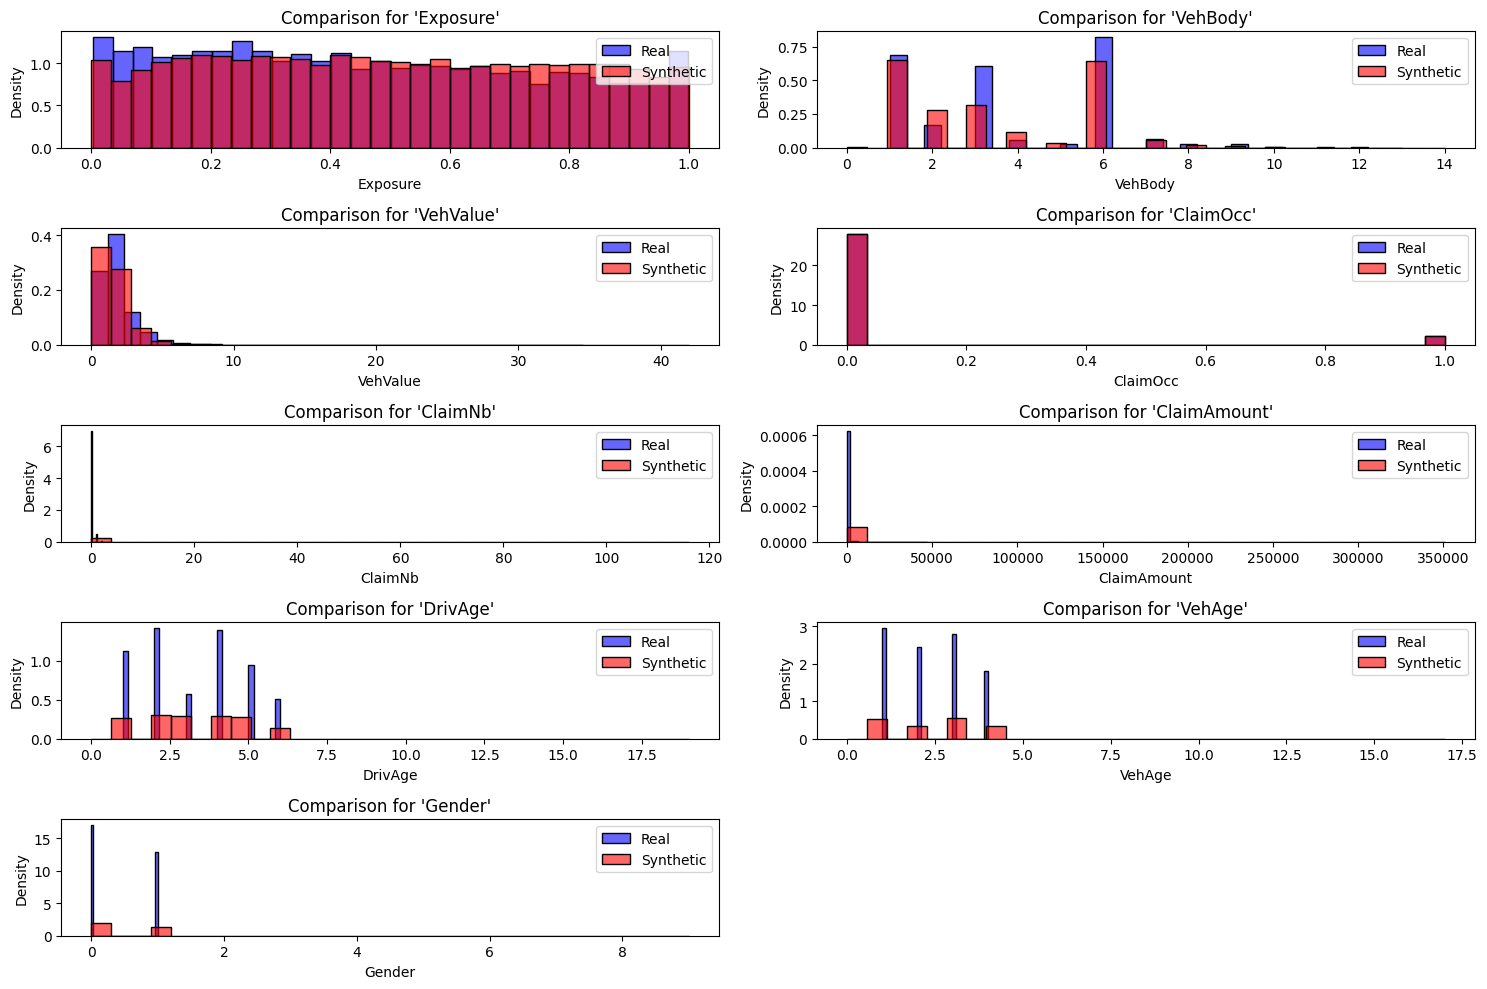

In [40]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=synthetic_data,
    columns=['Exposure','VehBody','VehValue','ClaimOcc','ClaimNb', 'ClaimAmount', 'DrivAge', 'VehAge','Gender'],
    kind='hist'
)


### Statistical Analysis

In [41]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for Exposure: Statistic=0.05001875468867217, P-value=2.0886939487169075e-58
KS Test for VehValue: Statistic=0.07464366091522884, P-value=1.2567861428692166e-129
KS Test for VehAge: Statistic=0.0441672918229557, P-value=1.2482865308651818e-45
KS Test for VehBody: Statistic=0.09238559639909977, P-value=1.801252499050668e-198
KS Test for Gender: Statistic=0.008458364591147793, P-value=0.0438380271096126
KS Test for DrivAge: Statistic=0.06277194298574645, P-value=9.104623967318944e-92
KS Test for ClaimOcc: Statistic=0.00011252813203299628, P-value=1.0
KS Test for ClaimNb: Statistic=0.0029444861215304208, P-value=0.9744148364921399
KS Test for ClaimAmount: Statistic=0.010727681920480125, P-value=0.004294824076604378


### PCA Analysis

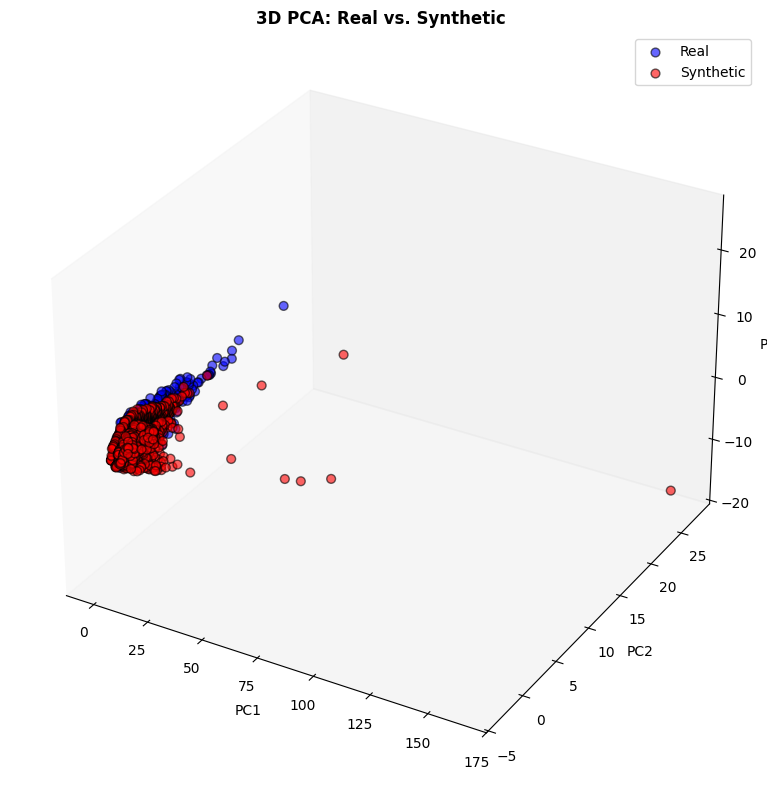

In [42]:
pca_visual_comparison_3d(X_train, synthetic_data, var='d1')


### UMAP Analysis

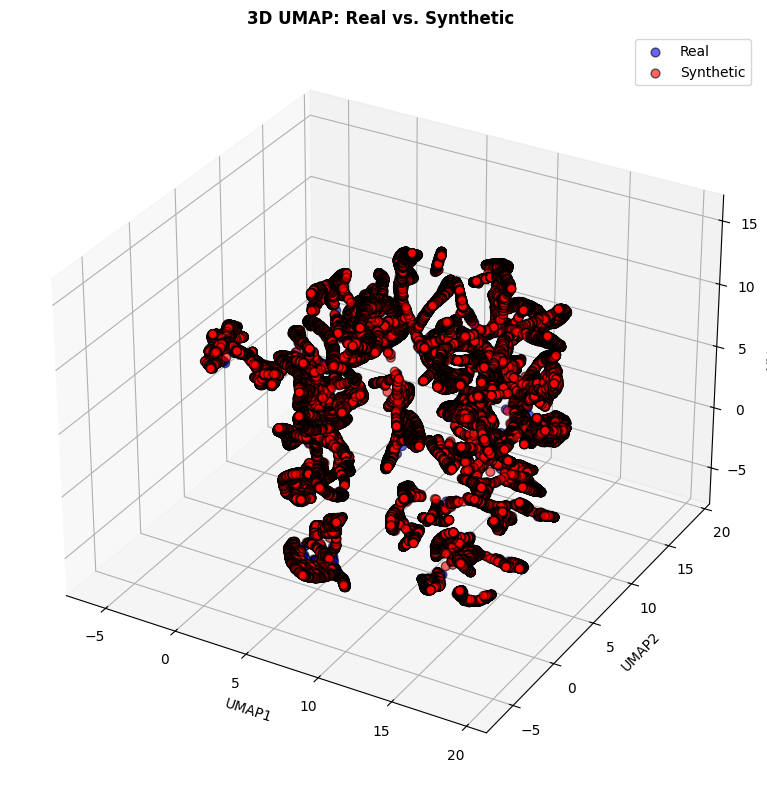

In [43]:
umap_visual_comparison_3d(X_train, synthetic_data, var='d1')

### GLM Frequency Analysis

In [44]:
# Baseline frequency model
results_frequency_1 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")



Fold 1 Poisson Deviance Score: 1.6448
Fold 2 Poisson Deviance Score: 1.3600
Fold 3 Poisson Deviance Score: 1.0406
Fold 4 Poisson Deviance Score: 1.8229
Fold 5 Poisson Deviance Score: 1.3053
Average cross-validation Poisson Deviance Score: 1.4347
Standard Deviation of CV Scores: 0.2729
Train Poisson Deviance: 1.4345
Test Poisson Deviance: 1.7412


In [45]:
# Using synthetic sample data with exposure clipping
results_frequency_2 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 0.9888
Fold 2 Poisson Deviance Score: 0.9203
Fold 3 Poisson Deviance Score: 1.1633
Fold 4 Poisson Deviance Score: 1.1361
Fold 5 Poisson Deviance Score: 1.0668
Average cross-validation Poisson Deviance Score: 1.0550
Standard Deviation of CV Scores: 0.0905
Train Poisson Deviance: 1.0477
Test Poisson Deviance: 1.7547


### GLM Cost Analysis

In [46]:
results_cost_1 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.5149
Fold 2 Gamma Deviance Score: 1.6084
Fold 3 Gamma Deviance Score: 1.4353
Fold 4 Gamma Deviance Score: 1.5815
Fold 5 Gamma Deviance Score: 1.6581
Average cross-validation Gamma Deviance Score: 1.5596604025666598
Standard Deviation of CV Scores: 0.07748353705257649
Train Gamma Deviance: 1.5509
Test Gamma Deviance: 1.7221


In [47]:
results_cost_2 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)


Fold 1 Gamma Deviance Score: 1.3076
Fold 2 Gamma Deviance Score: 1.4530
Fold 3 Gamma Deviance Score: 1.2426
Fold 4 Gamma Deviance Score: 1.3661
Fold 5 Gamma Deviance Score: 1.2361
Average cross-validation Gamma Deviance Score: 1.321073622013675
Standard Deviation of CV Scores: 0.08122576400843338
Train Gamma Deviance: 1.3152
Test Gamma Deviance: 1.7178


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


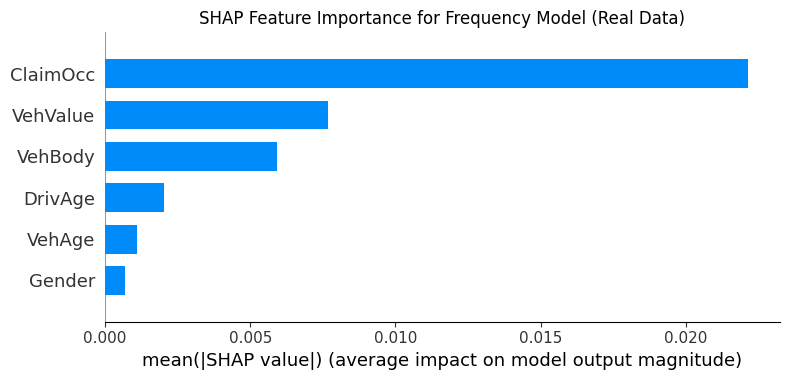


--- SHAP Feature Importance for Severity Model ---


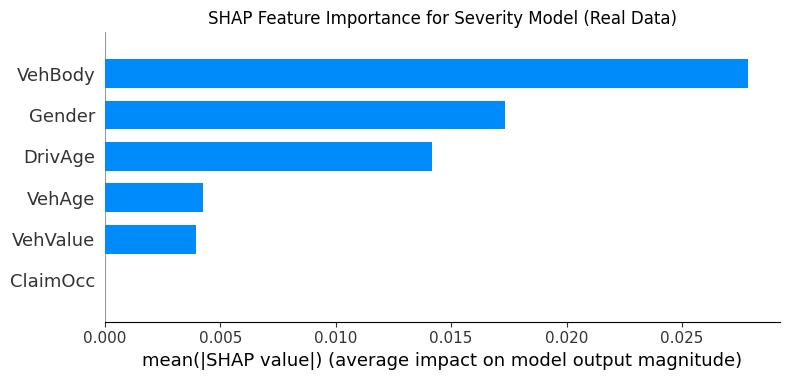

In [48]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


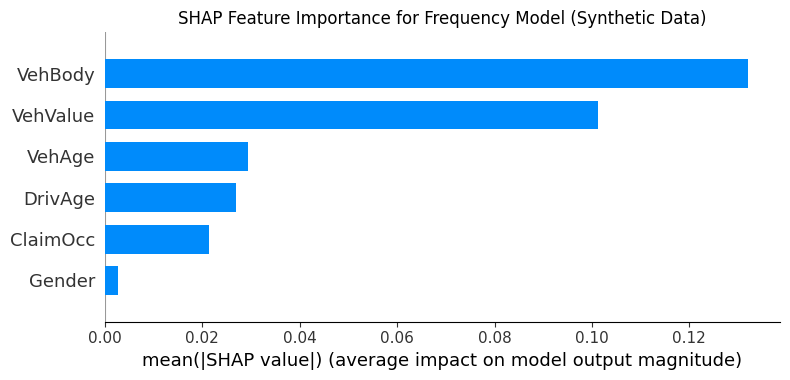


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


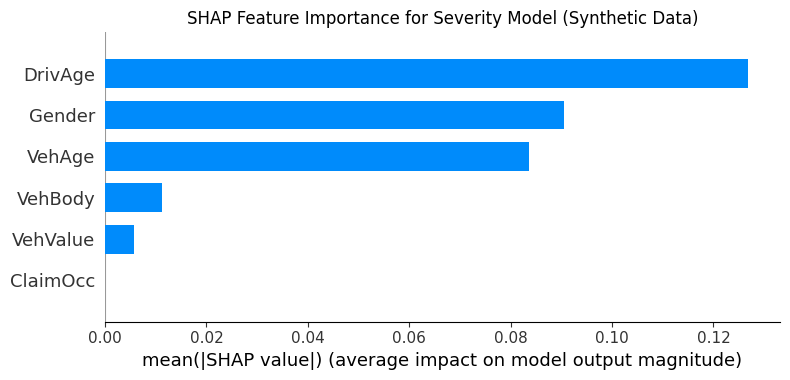

In [49]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Upload dataset and data handling

In [50]:
#---------------------
# D2
#---------------------
df2=pd.read_csv('/content/swmotorcycle.csv')

In [51]:
print(df2.shape)

(64548, 9)


In [52]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OwnerAge     64548 non-null  int64  
 1   Gender       64548 non-null  object 
 2   Area         64548 non-null  object 
 3   RiskClass    64548 non-null  object 
 4   VehAge       64548 non-null  int64  
 5   BonusClass   64548 non-null  object 
 6   Exposure     64548 non-null  float64
 7   ClaimNb      64548 non-null  int64  
 8   ClaimAmount  64548 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 4.4+ MB
None


In [53]:
print(df2.columns)

Index(['OwnerAge', 'Gender', 'Area', 'RiskClass', 'VehAge', 'BonusClass',
       'Exposure', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [54]:
df2.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0,0


In [55]:
df2_duplicated_rows=df2[df2.duplicated()]
df2_duplicated_rows

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount


In [56]:
df2=df2.drop_duplicates()

In [57]:
df2_duplicated_col=df2.columns[df2.columns.duplicated()]
df2_duplicated_col

Index([], dtype='object')

In [58]:
missing=df2.isnull().sum()/df2.shape[0]*100
missing

,0
OwnerAge,0.0
Gender,0.0
Area,0.0
RiskClass,0.0
VehAge,0.0
BonusClass,0.0
Exposure,0.0
ClaimNb,0.0
ClaimAmount,0.0


In [59]:
# add ClaimOcc feature
df_2 = df2.copy()
df_2['ClaimOcc'] = np.where(df_2['ClaimNb'] > 0, 1, 0)
# Feature transformation
df_2['Exposure'] = df_2['Exposure'].clip(upper=1)
df_2['VehAge'] = df_2['VehAge'].clip(upper=20)

### Encoding

In [60]:
print(df_2['Gender'].unique())
print(df_2['Area'].unique())
print(df_2['RiskClass'].unique())
print(df_2['BonusClass'].unique())


['Male' 'Female']
["Central parts of Sweden's three largest cities"
 'Lesser towns except Gotland; Northern towns'
 'Small towns; countryside except Gotland; Northern towns'
 'Suburbs; middle-sized cities' 'Northern countryside' 'Northern towns'
 "Gotland (Sweden's largest island)"]
['EV ratio 13-15' 'EV ratio 20-24' 'EV ratio 9-12' 'EV ratio <5'
 'EV ratio 6-8' 'EV ratio 16-19' 'EV ratio >25']
['BM1' 'BM2' 'BM3' 'BM4' 'BM7' 'BM5' 'BM6']


In [61]:
df2_encod=df_2.copy()
# RiskClass
RiskClass_group = {'EV ratio 13-15':'1','EV ratio 20-24':'2','EV ratio 9-12':'3','EV ratio <5':'4','EV ratio 6-8':'5',\
                   'EV ratio 16-19':'6','EV ratio >25':'7'}
df2_encod['RiskClass'] = df2_encod['RiskClass'].map(RiskClass_group)
df2_encod['RiskClass']= df2_encod['RiskClass'].astype(int)
# BonusClass
BonusClass_group = {'BM1':'1','BM2':'2','BM3':'3','BM4':'4','BM5':'5','BM6':'6','BM7':'7'}
df2_encod['BonusClass'] = df2_encod['BonusClass'].map(BonusClass_group)
df2_encod['BonusClass']= df2_encod['BonusClass'].astype(int)
# Area
Area_group = {"Central parts of Sweden's three largest cities":'1','Lesser towns except Gotland; Northern towns':'2',\
              'Small towns; countryside except Gotland; Northern towns':'3','Suburbs; middle-sized cities':'4',\
              'Northern countryside':'5','Northern towns':'6',"Gotland (Sweden's largest island)":'7'}
df2_encod['Area'] = df2_encod['Area'].map(Area_group)
df2_encod['Area']= df2_encod['Area'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df2_encod['Gender'] = df2_encod['Gender'].map(Gender_group)
df2_encod['Gender']= df2_encod['Gender'].astype(int)




In [62]:
df2_encod.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,0,1,1,1,12,1,0.175342,0,0,0
1,4,1,2,2,9,1,0.000000,0,0,0
2,5,0,2,3,18,1,0.454795,0,0,0
3,5,0,3,4,20,1,0.172603,0,0,0
4,6,0,4,4,20,1,0.180822,0,0,0


### Split dataset

In [63]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df2_encod, test_size=0.2, random_state=0)
# Split the dataset into train/test split for generative models
X_train2, X_test2 = train_test_split(df2_encod, test_size=0.4, random_state=0)


In [64]:
X_train2.shape

(38728, 10)

### Build a CDF

In [65]:
# Train
cdf2 = train_cdf_model(
    X_train=X_train2,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    t_emb_dim=64,
    beta_start=1e-4,
    beta_end=0.02,
    timesteps=1000,
    hidden_dim=512,
    epochs=20,
    batch_size=128,
    learning_rate=1e-3)


Epoch 1/20 - loss: 78.4782
Epoch 2/20 - loss: 57.9021
Epoch 3/20 - loss: 55.5447
Epoch 4/20 - loss: 55.0359
Epoch 5/20 - loss: 53.3703
Epoch 6/20 - loss: 53.3550
Epoch 7/20 - loss: 51.9933
Epoch 8/20 - loss: 52.2252
Epoch 9/20 - loss: 51.4745
Epoch 10/20 - loss: 52.0661
Epoch 11/20 - loss: 51.1167
Epoch 12/20 - loss: 51.6048
Epoch 13/20 - loss: 50.5946
Epoch 14/20 - loss: 50.5723
Epoch 15/20 - loss: 50.6981
Epoch 16/20 - loss: 50.3589
Epoch 17/20 - loss: 50.8628
Epoch 18/20 - loss: 50.7555
Epoch 19/20 - loss: 49.7033
Epoch 20/20 - loss: 50.1126


### Generate Samples

In [66]:

# Generate samples
synthetic_data = generate_cdf_synthetic_data(
    cdf_model=cdf2,
    num_samples=len(X_train),
    claim_occ_values=[0, 1],
    feature_names=cdf2['features'],          # excludes condition
    means=cdf2['means'],
    stds_corrected=cdf2['stds_corrected'],
    X_train=X_train2,
    condition_col='ClaimOcc',
    target_discrete='ClaimNb',
    target_continuous='ClaimAmount',
    timesteps=cdf2['timesteps'],
    condition_dim=cdf2['condition_dim'],
    columns_to_round=['VehAge','DrivAge','VehBody','Gender']
)


### Use Generate Samples Dataframe

In [67]:
new_samples_df=synthetic_data.copy()

In [68]:
new_samples_df.to_csv('d2_cdf_60_encod.csv')

In [69]:
df2_decod=new_samples_df.copy()
# RiskClass
RiskClass_group = {1:'EV ratio 13-15',2:'EV ratio 20-24',3:'EV ratio 9-12',4:'EV ratio <5',5:'EV ratio 6-8',\
                   6:'EV ratio 16-19',7:'EV ratio >25'}
df2_decod['RiskClass'] = df2_decod['RiskClass'].map(RiskClass_group)
# BonusClass
BonusClass_group = {1:'BM1', 2:'BM2',3: 'BM3', 4:'BM4',5:'BM5',6:'BM6',7:'BM7'}
df2_decod['BonusClass'] = df2_decod['BonusClass'].map(BonusClass_group)
# Area
Area_group = {1:"Central parts of Sweden's three largest cities",2:'Lesser towns except Gotland; Northern towns',\
              3:'Small towns; countryside except Gotland; Northern towns',4:'Suburbs; middle-sized cities',\
              5:'Northern countryside',6:'Northern towns',7:"Gotland (Sweden's largest island)"}
df2_decod['Area'] = df2_decod['Area'].map(Area_group)
# Gender
Gender_group = {0:'Female',1:'Male'}
df2_decod['Gender'] = df2_decod['Gender'].map(Gender_group)


In [70]:
df2_decod.to_csv('d2_cdf_60.csv')

### Data Comparison

In [71]:
X_train.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
17537,32,1,4,2,10,4,0.668493,0,0,0
36594,46,1,4,6,16,3,1.000000,0,0,0
49674,53,0,1,6,14,2,0.495890,0,0,0
60665,62,1,2,3,14,3,0.498630,0,0,0
28321,42,1,4,3,15,2,0.961644,0,0,0


In [72]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,42.381250,12.979286,0.0,31.000000,44.000000,52.0,92.0
Gender,51638.0,0.848581,0.358461,0.0,1.000000,1.000000,1.0,1.0
Area,51638.0,2.973643,1.253283,1.0,2.000000,3.000000,4.0,7.0
RiskClass,51638.0,3.356714,1.747525,1.0,2.000000,3.000000,5.0,7.0
VehAge,51638.0,11.114722,6.365856,0.0,5.000000,12.000000,16.0,20.0
BonusClass,51638.0,4.020508,2.364091,1.0,2.000000,4.000000,7.0,7.0
Exposure,51638.0,0.687829,0.332135,0.0,0.463014,0.821918,1.0,1.0
ClaimNb,51638.0,0.010535,0.105824,0.0,0.000000,0.000000,0.0,2.0
ClaimAmount,51638.0,260.434583,4748.164398,0.0,0.000000,0.000000,0.0,365347.0
ClaimOcc,51638.0,0.010148,0.100224,0.0,0.000000,0.000000,0.0,1.0


In [73]:
new_samples_df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,53.804062,1,1.805205,5.708261,3,7.059287,0.094480,0,0.0,0
1,34.072563,1,2.818110,5.611414,19,1.336168,0.492235,0,0.0,0
2,51.623489,1,3.902581,3.526701,19,4.411004,0.991588,0,0.0,0
3,50.190670,0,3.601946,0.997075,8,6.107940,0.239654,0,0.0,0
4,53.660954,1,1.755850,4.562604,19,1.287174,0.468997,0,0.0,0


In [74]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,41.967228,13.090208,0.000000,31.376602,41.928688,51.982594,8.253296e+01
Gender,51638.0,0.862195,0.348499,0.000000,1.000000,1.000000,1.000000,4.000000e+00
Area,51638.0,2.935094,1.207445,0.000000,2.055191,2.850590,3.709899,8.224960e+00
RiskClass,51638.0,3.556725,1.745868,0.000000,2.012089,3.487069,5.126006,7.689052e+00
VehAge,51638.0,11.418161,6.199865,0.000000,6.000000,12.000000,17.000000,2.400000e+01
BonusClass,51638.0,4.363199,2.304654,0.254133,2.059700,4.532453,6.773945,1.979628e+01
Exposure,51638.0,0.690416,0.327008,0.000000,0.413624,0.836840,0.986023,1.000000e+00
ClaimNb,51638.0,0.022406,0.307200,0.000000,0.000000,0.000000,0.000000,1.300000e+01
ClaimAmount,51638.0,519.757446,13387.252930,0.000000,0.000000,0.000000,0.000000,1.493166e+06
ClaimOcc,51638.0,0.009915,0.099081,0.000000,0.000000,0.000000,0.000000,1.000000e+00


In [75]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51114
Records where all three are positive: 524


In [76]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51126
Records where all three are positive: 471


In [77]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 41
       OwnerAge  Gender      Area  RiskClass  VehAge  BonusClass  Exposure  \
9     42.959232       1  2.636495   4.335229       9    1.987572  0.839018   
243   43.780949       1  3.479607   4.015084      19    6.679816  1.000000   
557   25.123568       1  4.030162   5.552786      16    4.910853  0.317809   
1658  28.122665       0  3.933580   1.625236       2    1.223727  0.590823   
3434  35.300663       1  3.110004   3.605672       0    6.306130  0.295257   

      ClaimNb  ClaimAmount  ClaimOcc  
9           0          0.0         1  
243         1          0.0         1  
557         1          0.0         1  
1658        0          0.0         1  
3434        1          0.0         1  


### Visual Comparison

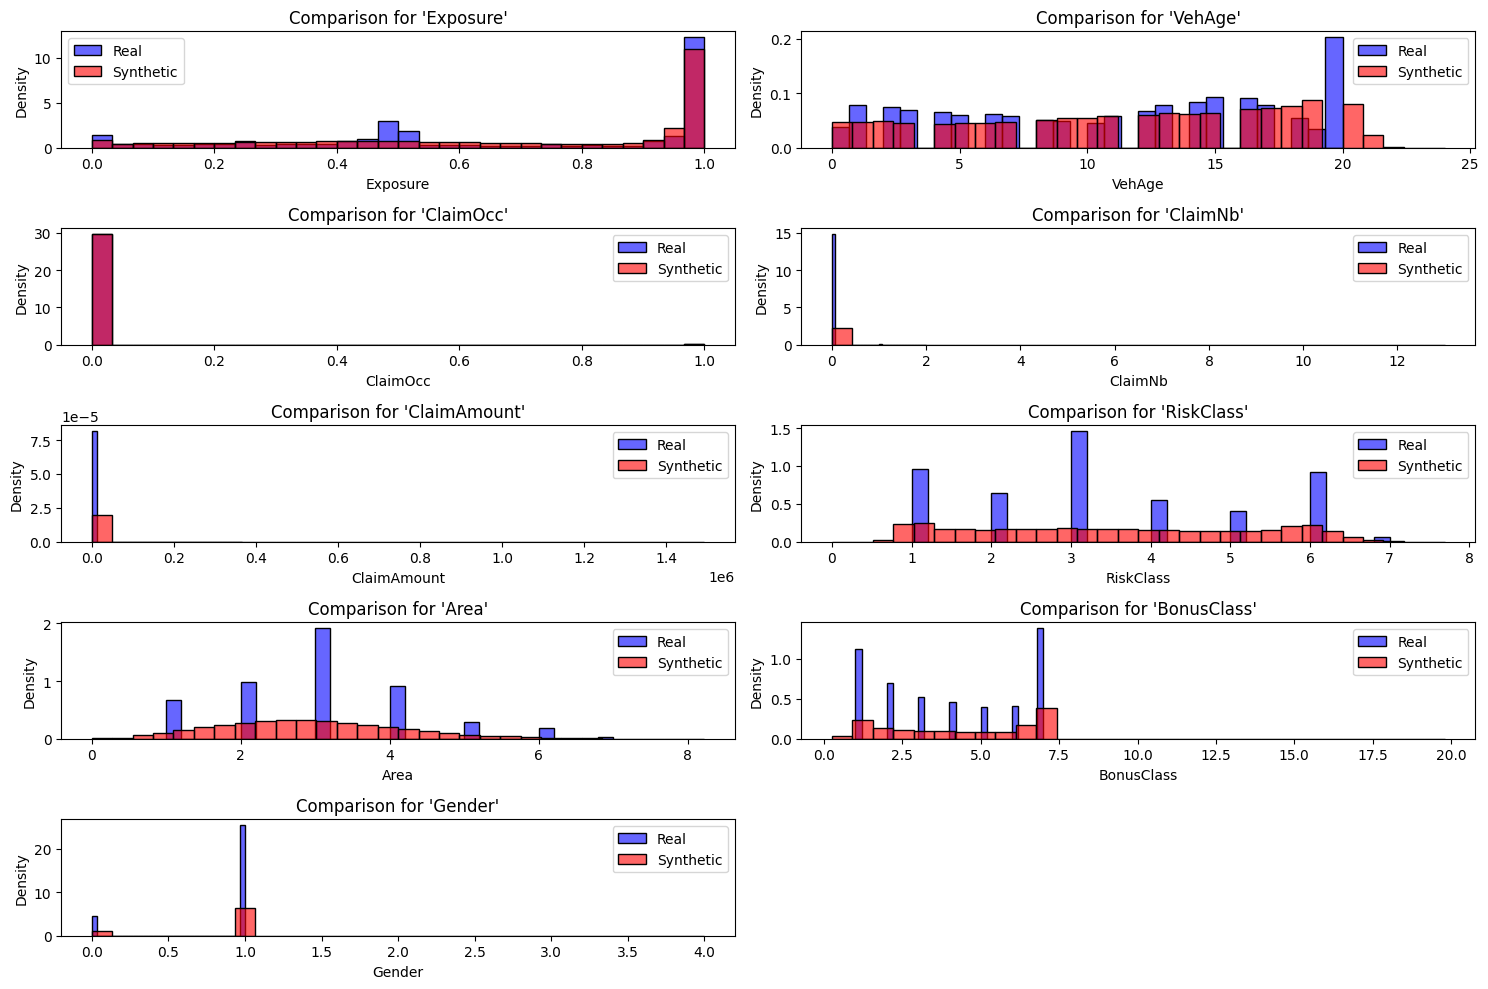

In [78]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=synthetic_data,
    columns=['Exposure','VehAge','ClaimOcc','ClaimNb', 'ClaimAmount', 'RiskClass', 'Area','BonusClass','Gender'],
    kind='hist'
)


### Statistical Analysis

In [79]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for OwnerAge: Statistic=0.07248537898446877, P-value=2.0578887830753497e-118
KS Test for Gender: Statistic=0.01249080134784461, P-value=0.0006286365599805129
KS Test for Area: Statistic=0.21927650180099928, P-value=0.0
KS Test for RiskClass: Statistic=0.19578604903365743, P-value=0.0
KS Test for VehAge: Statistic=0.05263565591231267, P-value=1.3068394467686589e-62
KS Test for BonusClass: Statistic=0.1777760563925791, P-value=0.0
KS Test for Exposure: Statistic=0.23990084821255664, P-value=0.0
KS Test for ClaimNb: Statistic=0.004647740036407222, P-value=0.630792842634619
KS Test for ClaimAmount: Statistic=0.0015879778457724703, P-value=0.9999999328540756
KS Test for ClaimOcc: Statistic=0.00023238700182037775, P-value=1.0


### PCA Analysis

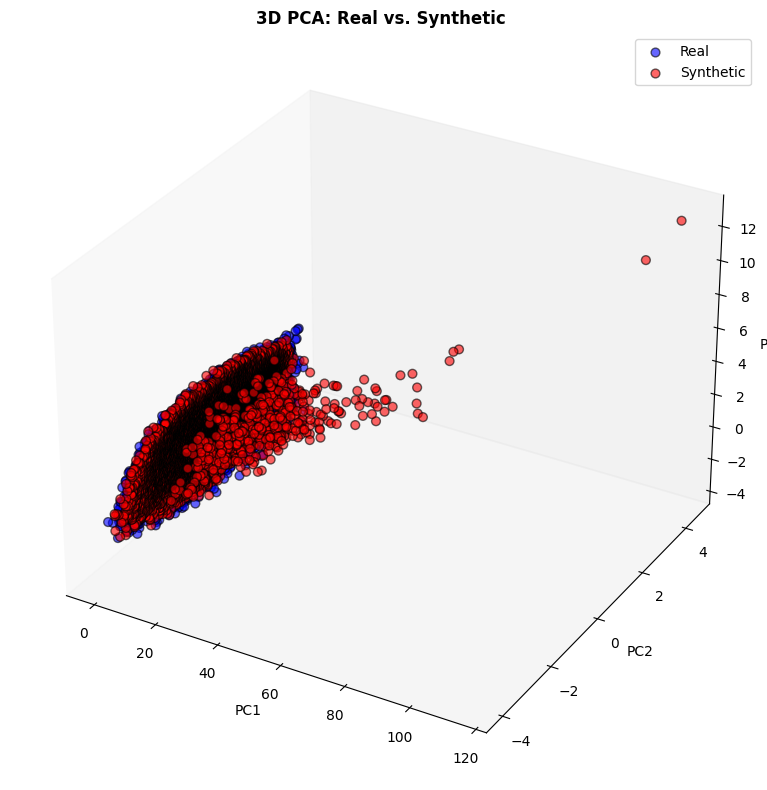

In [80]:
pca_visual_comparison_3d(X_train, synthetic_data, var='d2')

### UMAP Analysis

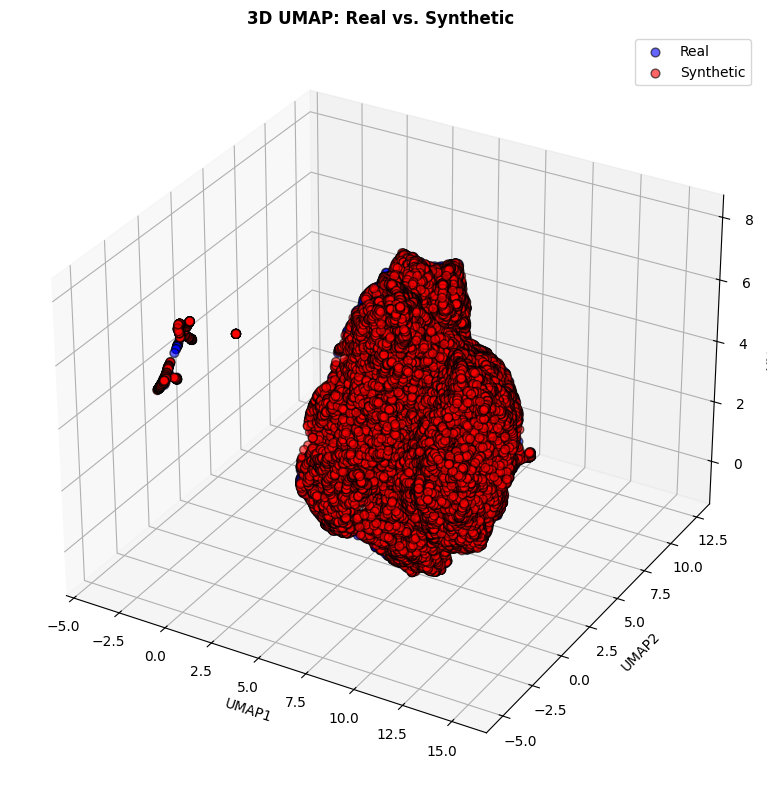

In [81]:
umap_visual_comparison_3d(X_train, synthetic_data, var='d2')

### GLM Frequency Analysis

In [82]:
# Baseline frequency model
results_frequency_3 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")


Fold 1 Poisson Deviance Score: 0.2113
Fold 2 Poisson Deviance Score: 0.2744
Fold 3 Poisson Deviance Score: 0.3212
Fold 4 Poisson Deviance Score: 0.3262
Fold 5 Poisson Deviance Score: 0.2611
Average cross-validation Poisson Deviance Score: 0.2788
Standard Deviation of CV Scores: 0.0423
Train Poisson Deviance: 0.2788
Test Poisson Deviance: 0.4368


In [83]:
# Using synthetic sample data with exposure clipping
results_frequency_4 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 0.7801
Fold 2 Poisson Deviance Score: 0.3757
Fold 3 Poisson Deviance Score: 0.3284
Fold 4 Poisson Deviance Score: 1.5290
Fold 5 Poisson Deviance Score: 0.3620
Average cross-validation Poisson Deviance Score: 0.6750
Standard Deviation of CV Scores: 0.4578
Train Poisson Deviance: 0.6742
Test Poisson Deviance: 0.3781


### GLM Cost Analysis

In [84]:
results_cost_3 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.8636
Fold 2 Gamma Deviance Score: 1.8794
Fold 3 Gamma Deviance Score: 1.6971
Fold 4 Gamma Deviance Score: 1.8394
Fold 5 Gamma Deviance Score: 1.8494
Average cross-validation Gamma Deviance Score: 1.825777294896016
Standard Deviation of CV Scores: 0.06574128033743543
Train Gamma Deviance: 1.7615
Test Gamma Deviance: 1.7251


In [85]:
results_cost_4 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)

Fold 1 Gamma Deviance Score: 1.1957
Fold 2 Gamma Deviance Score: 0.8124
Fold 3 Gamma Deviance Score: 0.8570
Fold 4 Gamma Deviance Score: 1.2262
Fold 5 Gamma Deviance Score: 0.9113
Average cross-validation Gamma Deviance Score: 1.0005183039588146
Standard Deviation of CV Scores: 0.1749202689167582
Train Gamma Deviance: 0.9679
Test Gamma Deviance: 1.8862


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


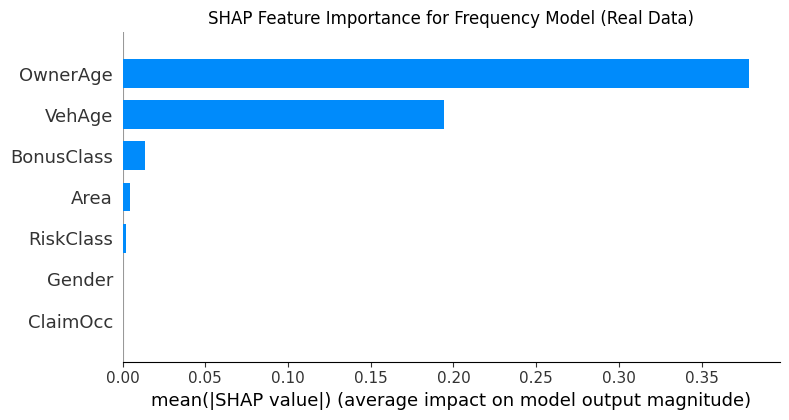


--- SHAP Feature Importance for Severity Model ---


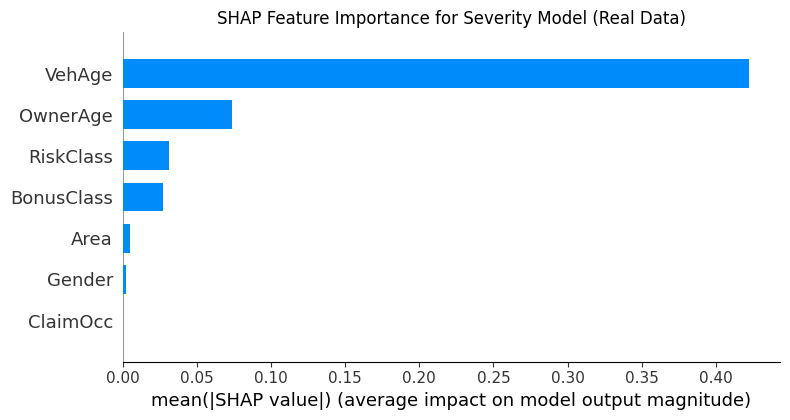

In [86]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


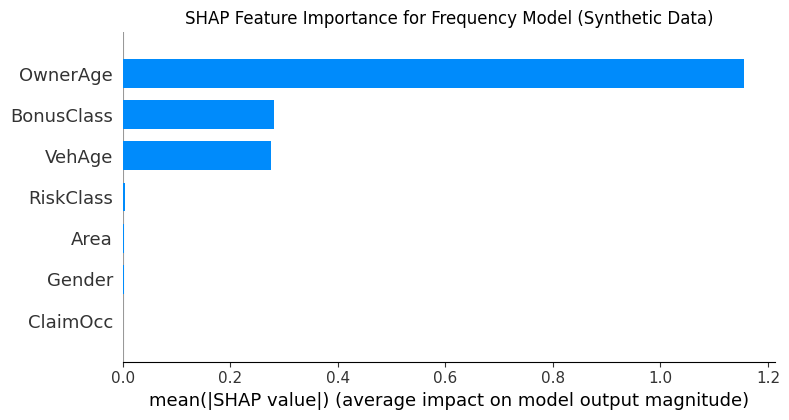


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


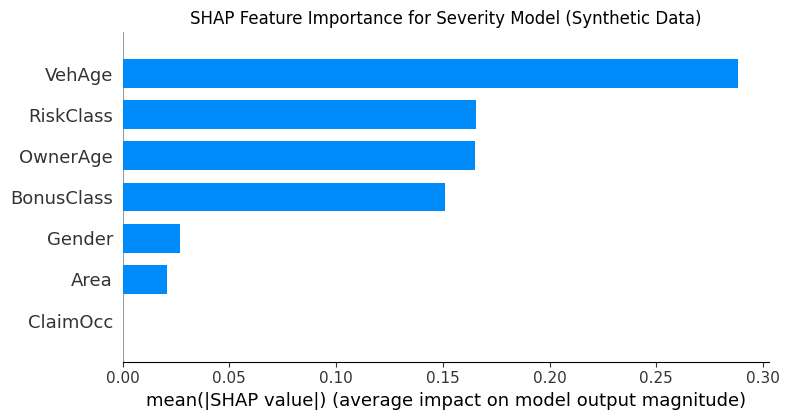

In [87]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Results

In [88]:
# The dictionary dataset 1
metrics_dict_1 = results_frequency_1[1]
mpd_train_1 = metrics_dict_1['mpd_train']
mpd_test_1 = metrics_dict_1['mpd_test']
print(f"mpd_train_1: {mpd_train_1}")
print(f"mpd_test_1: {mpd_test_1}")

mpd_train_1: 1.4344568519034897
mpd_test_1: 1.741190103494106


In [89]:
# The dictionary synthetic dataset 1
metrics_dict_2 = results_frequency_2[1]
mpd_train_2 = metrics_dict_2['mpd_train']
mpd_test_2 = metrics_dict_2['mpd_test']
print(f"mpd_train_2: {mpd_train_2}")
print(f"mpd_test_2: {mpd_test_2}")

mpd_train_2: 1.0476978373400114
mpd_test_2: 1.7547023417602852


In [90]:
# The dictionary dataset 2
metrics_dict_3 = results_frequency_3[1]
mpd_train_3 = metrics_dict_3['mpd_train']
mpd_test_3 = metrics_dict_3['mpd_test']
print(f"mpd_train_3: {mpd_train_3}")
print(f"mpd_test_3: {mpd_test_3}")

mpd_train_3: 0.2787767739809314
mpd_test_3: 0.4367935890535355


In [91]:
# The dictionary synthetic dataset 2
metrics_dict_4 = results_frequency_4[1]
mpd_train_4 = metrics_dict_4['mpd_train']
mpd_test_4 = metrics_dict_4['mpd_test']
print(f"mpd_train_4: {mpd_train_4}")
print(f"mpd_test_4: {mpd_test_4}")

mpd_train_4: 0.674160506228914
mpd_test_4: 0.3781406078884263


In [92]:
# The dictionary dataset 1
mgd_train_1 = results_cost_1['mgd_train']
mgd_test_1 = results_cost_1['mgd_test']
print(f"mgd_train_1: {mgd_train_1}")
print(f"mgd_test_1: {mgd_test_1}")

mgd_train_1: 1.5508741472884893
mgd_test_1: 1.7221300040077396


In [93]:
# The dictionary synthetic dataset 1
mgd_train_2 = results_cost_2['mgd_train']
mgd_test_2 = results_cost_2['mgd_test']
print(f"mgd_train_2: {mgd_train_2}")
print(f"mgd_test_2: {mgd_test_2}")

mgd_train_2: 1.315232323584207
mgd_test_2: 1.7178221508231526


In [94]:
# The dictionary dataset 2
mgd_train_3 = results_cost_3['mgd_train']
mgd_test_3 = results_cost_3['mgd_test']
print(f"mgd_train_3: {mgd_train_3}")
print(f"mgd_test_3: {mgd_test_3}")

mgd_train_3: 1.7615204909151378
mgd_test_3: 1.7250831816188326


In [95]:
# The dictionary synthetic dataset 2
mgd_train_4 = results_cost_4['mgd_train']
mgd_test_4 = results_cost_4['mgd_test']
print(f"mgd_train_4: {mgd_train_4}")
print(f"mgd_test_4: {mgd_test_4}")

mgd_train_4: 0.9678839389055698
mgd_test_4: 1.886209096004378


In [96]:
# Create the DataFrame
results_df1 = {
    'mpd_train': mpd_train_1,
    'mpd_test': mpd_test_1,
    'mgd_train': mgd_train_1,
    'mgd_test': mgd_test_1,
}
results_df2 = {
    'mpd_train': mpd_train_2,
    'mpd_test': mpd_test_2,
    'mgd_train': mgd_train_2,
    'mgd_test': mgd_test_2,
}
results_df3 = {
    'mpd_train': mpd_train_3,
    'mpd_test': mpd_test_3,
    'mgd_train': mgd_train_3,
    'mgd_test': mgd_test_3,
}
results_df4 = {
    'mpd_train': mpd_train_4,
    'mpd_test': mpd_test_4,
    'mgd_train': mgd_train_4,
    'mgd_test': mgd_test_4,
}
d1=pd.DataFrame(results_df1, index=['dataset 1'])
d2=pd.DataFrame(results_df2, index=['synthetic dataset 1'])
d3=pd.DataFrame(results_df3, index=['dataset 2'])
d4=pd.DataFrame(results_df4, index=['synthetic dataset 2'])
df_tot= pd.concat([d1,d2,d3,d4])
df_tot

,mpd_train,mpd_test,mgd_train,mgd_test
dataset 1,1.434457,1.741190,1.550874,1.722130
synthetic dataset 1,1.047698,1.754702,1.315232,1.717822
dataset 2,0.278777,0.436794,1.761520,1.725083
synthetic dataset 2,0.674161,0.378141,0.967884,1.886209


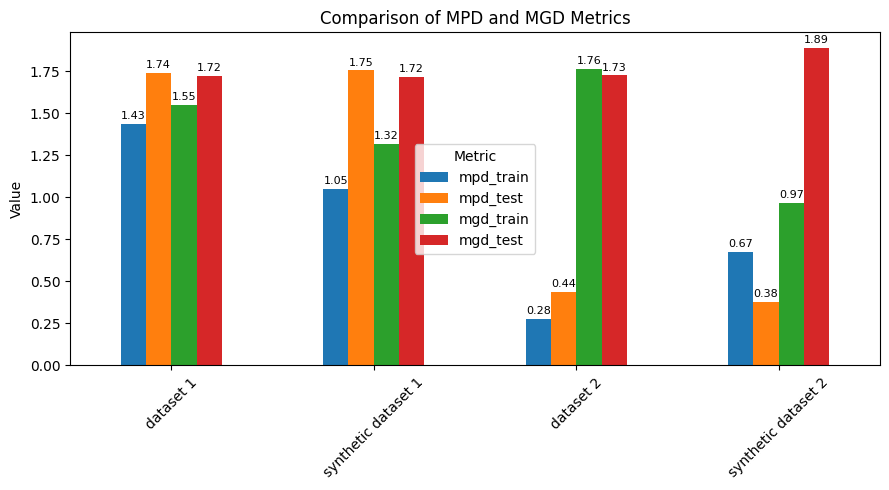

In [97]:
# Set up the plot
ax = df_tot.plot(kind='bar', figsize=(9, 5))

# Labels and title
plt.title('Comparison of MPD and MGD Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Add value labels with smaller font size
for container in ax.containers:
    labels = ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)
    for label in labels:
        label.set_fontsize(8)

plt.tight_layout()
plt.show()

